# <center>🥂 Shaken Not Stirred 🃏</center>

# Imports and setup

In [9]:
from fluid_2 import OceanBloodSimulation
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from IPython.display import HTML


# diffusion coefficient of liquids

### Wilke and Chang Diffusion Coefficient

The **Wilke–Chang equation** is an empirical formula used to estimate the diffusion coefficient of two liquids

#### Equation


#### Reference
Wilke, C.R., and Chang, P. (1955).  
*Correlation of diffusion coefficients in dilute solutions.* **AIChE Journal**, 1(2), 264–270.  
https://doi.org/10.1002/aic.690010222


In [10]:
viscosities = {"gin": 0.001, "water": 0.001, "vermouth": 0.001}        # Pa·s
molecular_weights = {"gin": 0.060, "water": 0.018, "vermouth": 0.130}  # kg/mol 
molar_volumes = {
  "gin": (58 * 0.4 + 18 * 0.6) * 1e-6,        # m³/mol
  "water": 18 * 1e-6,                         # m³/mol
  "vermouth": (58 * 0.2 + 18 * 0.8) * 1e-6    # m³/mol
}

In [11]:
def wilke_chang_diffusion(solute="vermouth", solvent="gin", phi=2.6, temperature=290):
    """
    Estimate diffusion coefficient D_AB of a solute in a solvent
    using the Wilke-Chang equation in SI units.
    
    Parameters:
    - solute (str): Name of the solute
    - solvent (str): Name of the solvent
    - phi (float): Association factor (default: 2.6 for ethanol/water solvents)
    - temperature (float): Temperature in Kelvin

    Returns:
    - D_AB (float): Diffusion coefficient in m²/s
    """
    mu = viscosities[solvent]*1000         # Pa·s to cP
    M_B = molecular_weights[solvent]*1000  # kg/mol to g/mol
    V_A = molar_volumes[solute]*1e6        # m³/mol cm^3/mol
    T_K = temperature                # Temperature in Kelvin

    # Calculate diffusion coefficient using Wilke-Chang equation
    D_AB = (7.4e-12 * (phi * M_B) ** 0.5 * T_K) / (mu * V_A ** 0.6)  # m²/s
    return D_AB

# Assume phi of gin and vermouth to be 2.6
# Assume temperature to be 290K
G_V_DIFFUSION = wilke_chang_diffusion(solute="vermouth", solvent="gin", phi=2.6, temperature=290)

In [12]:
G_V_DIFFUSION # in m²/s

3.7949670374289024e-09

# Running simulations

In [13]:
common_params = {
    'grid_size': 100, 
    'domain_size': 20, #in m?
    'diffusion_coef': G_V_DIFFUSION, # in m²/s
    'viscosity': viscosities["gin"], # in Pa·s
    'dt': 0.1, 
    'pressure_iterations': 75
}
num_steps = 100
history_save_interval = 5 # Must match vis update time calc: time = frame * interval * dt

# stirring 

In [14]:
#Combined Shake (osc + eddies)
stirred_mode_params = {
  'mode': 'stirring', 
  'stir_strength': 1.5 # ?? units
  }

stirred_outfile = 'martini_stirring.mp4'


In [ ]:
print(f"{stirred_mode_params['mode'].upper()} SIMULATION ---")
print("Running simulation...")

stirred = OceanBloodSimulation(**common_params, **stirred_mode_params)
stirred.source(x_pos=2, y_pos=2, volumeOfBlob=1, std=2.8) # Martini ratio blob this is in grid units

conc_history, vel_history = stirred.looptheSim(steps=num_steps)
print(f"Final avg concentration: {np.mean(conc_history[-1]):.6f}")
print(f"Final max concentration: {np.max(conc_history[-1]):.6f}")


STIRRING SIMULATION ---
Running simulation...
Simulation initialized in 'stirring' mode.
Added source: peak=1.00, std=2.00 (grid std 10.00).
Initial total mass: 25.1308
Starting simulation (stirring) for 100 steps with dt=0.1...
Step 1/100. Time: 0.10. Max Vel: 1.416. Total Conc: 25.1308. Elapsed: 0.15s
Step 51/100. Time: 5.10. Max Vel: 6.276. Total Conc: 25.1308. Elapsed: 4.39s
Step 100/100. Time: 10.00. Max Vel: 6.276. Total Conc: 25.1308. Elapsed: 8.33s
Simulation finished in 8.33 seconds.
History lengths: Conc=21, Vel=21
Final avg concentration: 0.062827
Final max concentration: 0.103042


In [28]:
save_animation = False

print("\nVisualizing Results...")
try:
    stirred_animation = stirred.visualisequiver(conc_history, vel_history)
except Exception as e:
    print(f"Visualization error: {e}")
    import traceback; traceback.print_exc()

if save_animation:
    stirred_animation.save(stirred_outfile, writer='pillow', fps=10)
    print("Animation saved...")
    
HTML(stirred_animation.to_jshtml())


Visualizing Results...


# shaking

In [29]:
#Combined Shake (osc + eddies)
shaken_mode_params = {
    'mode': 'combined_shake',
    'shake_accel_amplitude': 50,   # Amplitude of oscillation
    'shake_frequency': 4,          # Fq of oscillation
    'random_amplitude': 0.75,         # Amp of eddies
    'random_correlation_sigma': 6.0,  # Size of eddies
}

shaken_outfile = 'martini_combined_shake.gif'


In [ ]:
print(f"{shaken_mode_params['mode'].upper()} SIMULATION ---")
print("Running simulation...")

shaken = OceanBloodSimulation(**common_params, **shaken_mode_params)
shaken.source(x_pos=2, y_pos=2, volumeOfBlob=1.0, std=2.8) # Martini ratio blob

conc_history, vel_history = shaken.looptheSim(steps=num_steps)
print(f"Final avg concentration: {np.mean(conc_history[-1]):.6f}")
print(f"Final max concentration: {np.max(conc_history[-1]):.6f}")


COMBINED_SHAKE SIMULATION ---
Running simulation...
Simulation initialized in 'combined_shake' mode.
Added source: peak=1.00, std=2.00 (grid std 10.00).
Initial total mass: 25.1308
Starting simulation (combined_shake) for 100 steps with dt=0.1...
Step 1/100. Time: 0.10. Max Vel: 1.982. Total Conc: 25.1308. Elapsed: 0.10s
Step 51/100. Time: 5.10. Max Vel: 7.545. Total Conc: 25.1308. Elapsed: 3.90s
Step 100/100. Time: 10.00. Max Vel: 6.834. Total Conc: 25.1308. Elapsed: 7.71s
Simulation finished in 7.71 seconds.
History lengths: Conc=21, Vel=21
Final avg concentration: 0.062827
Final max concentration: 0.412126


In [31]:
save_animation = False

print("\nVisualizing Results...")
try:
    shaken_animation = shaken.visualisequiver(conc_history, vel_history)
except Exception as e:
    print(f"Visualization error: {e}")
    import traceback; traceback.print_exc()

if save_animation:
    shaken_animation.save(shaken_outfile, writer='pillow', fps=10)
    print("Animation saved...")
    
HTML(shaken_animation.to_jshtml())


Visualizing Results...


# Plot distributions

In [100]:
def plot_distribution(fluidsimulation):
    grid = fluidsimulation.concentration.copy()

    # convert concentration to parts per million
    #grid = grid * 1000
    
    # Plot the final state using the figure method
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(grid, cmap='Blues', interpolation='nearest')
    cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    cbar.set_label('Relative Concentration', rotation=270, labelpad=15)
    ax.axis('off')  # Remove x and y axis
    plt.title("Final State")
    plt.show()


    # Flatten the grid to get the distribution of values but make sure nnot to include outside of cup boundary
    
    for i in range(fluidsimulation.grid_size):
        for j in range(fluidsimulation.grid_size):
            x, y = fluidsimulation.x[j], fluidsimulation.y[i]

            if np.sqrt(x**2 + y**2) >= fluidsimulation.grid_size / fluidsimulation.domain_size * 1.8:
                grid[i,j] = -1

    values = grid.flatten()
    values = values[values >= 0]  # Filter out negative values

    sns.set_theme()
    dist_plot = sns.histplot(values, kde=True, binwidth=0.0001)
    dist_plot.set(xlabel='Relative Concentration')

    mean = np.mean(values)
    variance = np.var(values)

    # print how many parts in grid
    print(f"Total parts in grid: {np.sum(values)}")
    print(f"Mean: {mean:.3g}, Variance: {variance:.3g}")
    display(dist_plot)

    
    return values

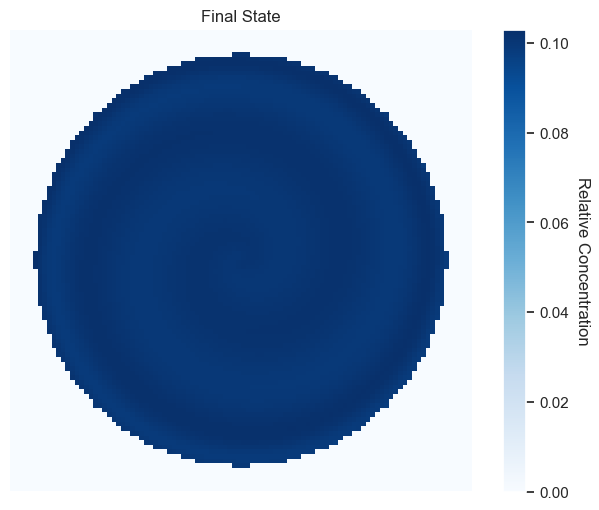

Total parts in grid: 628.2697629921662
Mean: 0.101, Variance: 1.25e-06


<AxesSubplot:xlabel='Relative Concentration', ylabel='Count'>

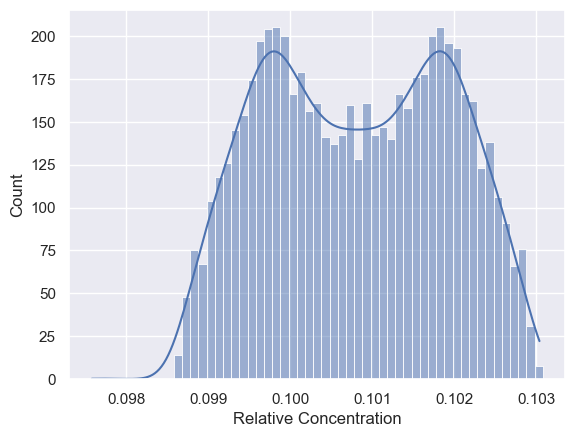

In [101]:
stirred_values = plot_distribution(stirred)

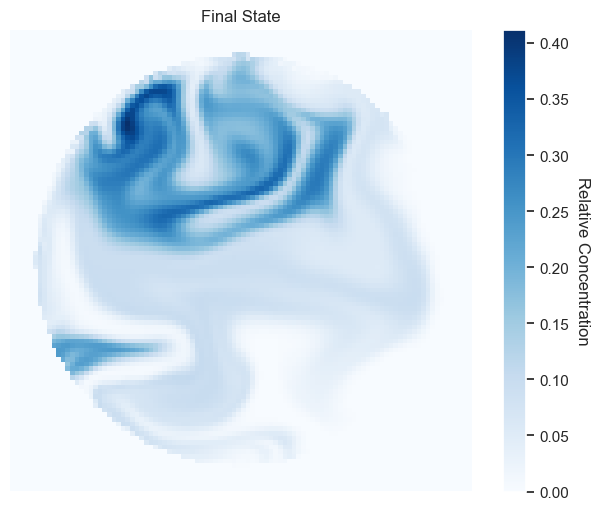

Total parts in grid: 628.2697632075972
Mean: 0.101, Variance: 0.00741


<AxesSubplot:xlabel='Relative Concentration', ylabel='Count'>

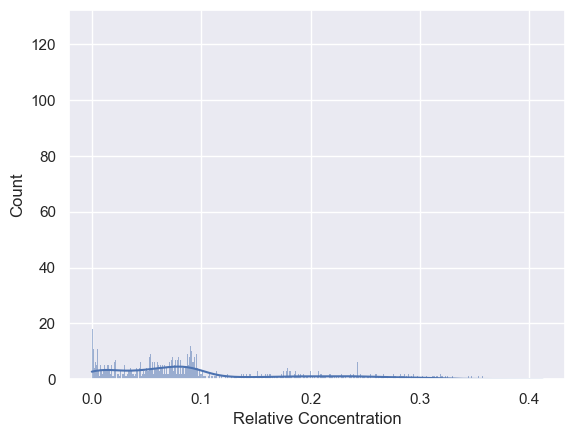

In [102]:
shaken_values = plot_distribution(shaken)

## double plot

<AxesSubplot:xlabel='Concentration', ylabel='Density'>

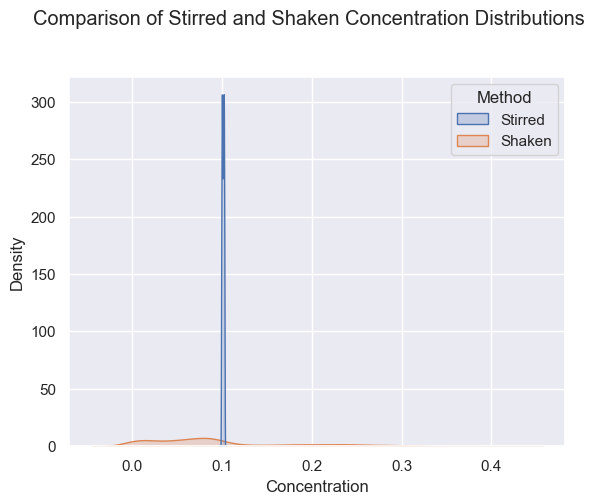

In [105]:
# Create the dataframe
df_distributions = pd.DataFrame({
    'Concentration': np.concatenate((stirred_values, shaken_values)),
    'Method': ['Stirred'] * len(stirred_values) + ['Shaken'] * len(shaken_values)
})




sns.set_theme()
plot = sns.kdeplot(data=df_distributions, x="Concentration", hue="Method", fill=True, common_norm=False)
plot.figure.suptitle("Comparison of Stirred and Shaken Concentration Distributions", y=1.02)
sns.move_legend(plot, "upper right")

display(plot)


<AxesSubplot:title={'center':'Comparison of Stirred and Shaken Concentration Distributions'}, xlabel='Method', ylabel='Concentration'>

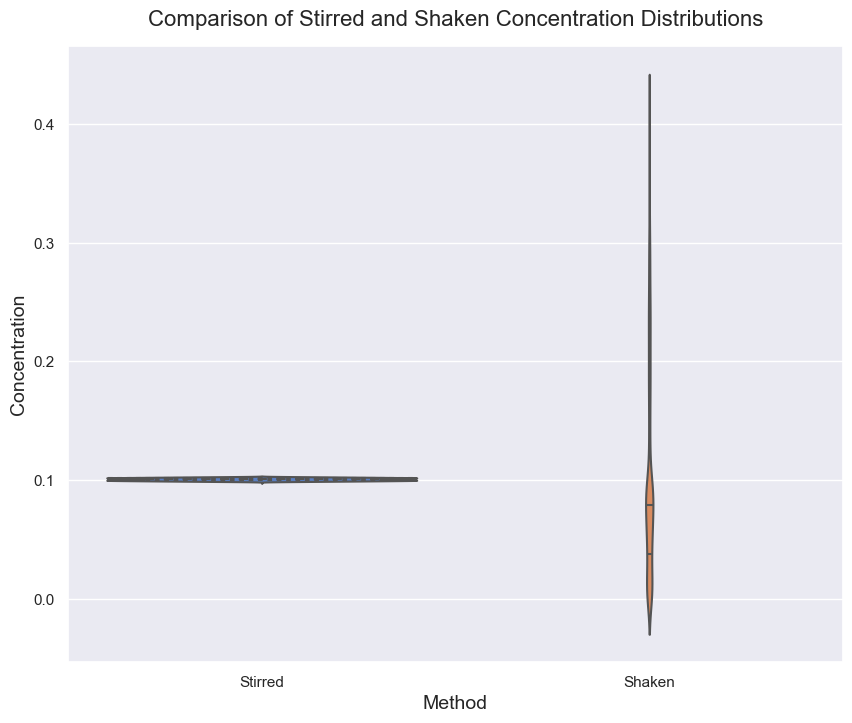

In [106]:
plt.figure(figsize=(10, 8))  # Increase figure size
sns.set_theme()  # Use a clean theme
plot = sns.violinplot(
  data=df_distributions, 
  x="Method", 
  y="Concentration", 
  inner="quartile", 
  palette="muted"  # Use a muted color palette
)
plot.set_title("Comparison of Stirred and Shaken Concentration Distributions", fontsize=16, y=1.02)
plot.set_xlabel("Method", fontsize=14)
plot.set_ylabel("Concentration", fontsize=14)

display(plot)